Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  6 of 6 completed

Portfolio VaR at 5% confidence: -0.1634196993818466
Portfolio CVaR at 5% confidence: -0.19819527231282943


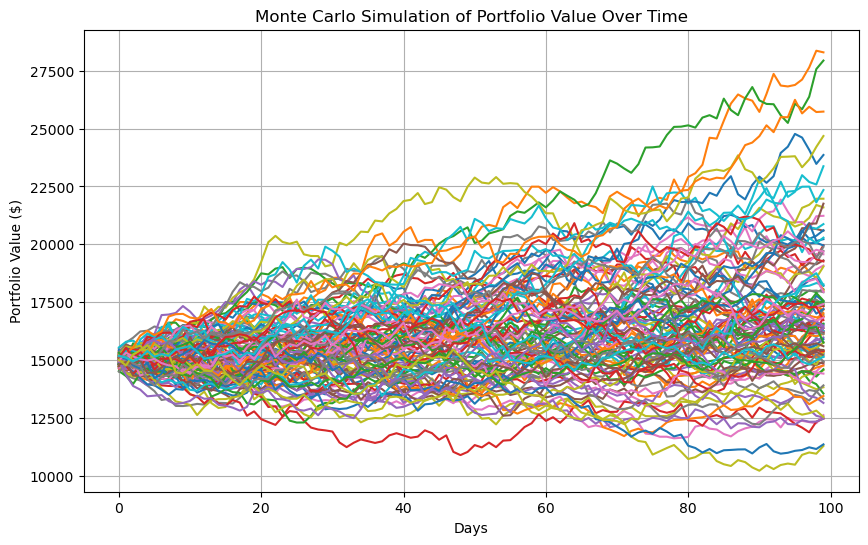

In [16]:
%pip install yfinance
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

# Importing the data
def get_data(stocks, start, end):
    stock_data = yf.download(stocks, start=start, end=end)
    stock_data = stock_data["Close"]
    returns = stock_data.pct_change().dropna()
    cov_matrix = returns.cov()
    returns_mean = returns.mean()
    return returns_mean, cov_matrix

stocks = ['MSFT', 'AAPL', 'TSLA', 'AMZN', 'NFLX', 'GOOG']
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365)

returns_mean, cov_matrix = get_data(stocks, start_date, end_date)

weights = np.random.random(len(returns_mean))
weights /= np.sum(weights)
nb_sim = 100 # number of simulations
T = 100  # time horizon in days
init_portfolio = 15000  # initial investment 

# Prepare Cholesky decomposition for correlated returns
L = np.linalg.cholesky(cov_matrix)

# Matrix to hold all portfolio simulations
portfolio_sims = np.zeros((T, nb_sim))

# Simulate
for m in range(nb_sim):
    Z = np.random.normal(size=(T, len(weights)))    # Random shocks
    correlated_randoms = Z @ L.T                    # Apply Cholesky to create correlated shocks
    daily_returns = returns_mean.values + correlated_randoms  # Add drift (mean returns)
    portfolio_growth = np.cumprod(1 + daily_returns @ weights) * init_portfolio
    portfolio_sims[:, m] = portfolio_growth
    
#plot
plt.figure(figsize=(10,6))
plt.plot(portfolio_sims)
plt.title('Monte Carlo Simulation of Portfolio Value Over Time')
plt.xlabel('Days')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
# plt.show()

def VaR(returns, alpha = 5):
    """
    Input - pandas series of returns
    Output - percintale on return destributions for the given confidance level alpha 
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else: 
        raise TypeError("Expect Pandas Data Series")   
        
def CVaR(returns, alpha = 5):
    """
    Input - pandas series of returns
    Output - expected loss in the worst-case scenarios, exceeding the VaR
    """
    if isinstance(returns, pd.Series):
        below_var = returns <= VaR(returns, alpha = alpha)
        return returns[below_var].mean()
    else: 
        raise TypeError("Expect Pandas Data Series")   

# last day portfolio values from each simulation
final_portfolio_values = pd.Series(portfolio_sims[-1, :])

# returns relative to initial investment
portfolio_returns = (final_portfolio_values - init_portfolio) / init_portfolio

# Calculate VaR and CVaR at 5% confidence level
var_5 = VaR(portfolio_returns, alpha=5)
cvar_5 = CVaR(portfolio_returns, alpha=5)


print(f"Portfolio VaR at 5% confidence: {var_5}")
print(f"Portfolio CVaR at 5% confidence: {cvar_5}")
